# Import thư viện cần thiết

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Import Random Forest Classifier model library
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

Đọc dữ liệu

In [2]:
train = pd.read_csv('../data/train_preprocessed.csv')
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,0.0,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,0.0,0,8,0,1,1,0,0.0,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [3]:
test = pd.read_csv('../data/test_preprocessed.csv')
test.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,0.0,0,5,0,1,1,0,0.0,1,...,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,0.0,0,5,0,1,1,0,0.0,1,...,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,0.0,0,5,0,1,1,0,0.0,1,...,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,0.0,0,14,0,1,1,1,1.0,0,...,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,...,18,121,324,1,0,1,0.25,64.00,121.00,324


In [4]:
ntrain = train.shape[0]
ntest = test.shape[0]

all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.tail()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
33408,ID_a065a7cad,0.0,1,2,1,1,1,0,0.0,0,...,9,100,36,25,4,36.0,0.25,33.0625,100,NaN
33409,ID_1a7c6953b,0.0,0,3,0,1,1,0,0.0,0,...,36,2916,16,36,4,4.0,1.00,36.0000,2916,NaN
33410,ID_07dbb4be2,0.0,0,3,0,1,1,0,0.0,0,...,16,144,16,36,4,4.0,1.00,36.0000,144,NaN
33411,ID_34d2ed046,0.0,0,3,0,1,1,0,0.0,0,...,25,144,16,36,4,4.0,1.00,36.0000,144,NaN
33412,ID_34754556f,0.0,0,3,0,1,1,0,0.0,0,...,36,2601,16,36,4,4.0,1.00,36.0000,2601,NaN


# Quan sát và xử lý dữ liệu đầu vào

## Quan sát dữ liệu

Kích thước dữ liệu.

In [5]:
print('Kích thước tập dữ liệu', all_data.shape, '. Trong đó:\n',
      '- Tập dữ liệu huấn luyện:', train.shape, ';\n',
      '- Tập dữ liệu kiểm thử:', test.shape, '.')

Kích thước tập dữ liệu (33413, 143) . Trong đó:
 - Tập dữ liệu huấn luyện: (9557, 143) ;
 - Tập dữ liệu kiểm thử: (23856, 142) .


Sự chênh lệch dữ liệu là do tập dữ liệu test không chứa biến dự đoán `target`.

Quan sát các biến định tính và định lượng.

In [6]:
numerical_cols = all_data.select_dtypes(include=np.number).columns.tolist()
categorical_cols = list(set(all_data.columns).difference(set(numerical_cols)))

categorical_cols

['Id', 'idhogar']

Quan sát những biến bị thiếu dữ liệu.

In [7]:
# Compute missing values for all columns
all_data.isnull().sum().sort_values(ascending=False)

Target          23856
hogar_mayor         0
parentesco10        0
parentesco11        0
parentesco12        0
                ...  
coopele             0
sanitario1          0
sanitario2          0
sanitario3          0
eviv2               0
Length: 143, dtype: int64

Ngoại trừ biến dự đoán, ta thấy các biến còn lại không có sự xuất hiện dữ liệu bị thiếu.

## Xử lý dữ liệu

### Loại bỏ các thuộc tính không cần thiết

Đầu tiên, cố gắng giảm chiều đối với những biến có thể chuyển từ định tính không thứ tự `one-hot encoding/nominal` sang định tính có thứ tự `ordinal`. Sau khi quan sát ý nghĩa của từng biến, các biến `epared_`, `etecho_` và `eviv_` có cách biểu diễn ý nghĩa mức độ giống nhau, cụ thể đều có 3 giá trị ý nghĩa `bad`, `regular` và `good`. Ta sẽ giảm chiều các biến này và quy ước: `0` - `bad`, `1` - `regular` và `2` - `good`.

In [8]:
def covert_nominal_to_ordinal(df, cols_lst):
    for ele in cols_lst:
        cols_spe = [col for col in df.columns if ele in col]
        spe_df = df[cols_spe].copy()
        spe_df.iloc[:,0] = (spe_df.iloc[:,0] * 0 + spe_df.iloc[:,0] * 1 + spe_df.iloc[:,0] * 2).astype(int)
        df.loc[:,cols_spe[0]] = spe_df[cols_spe[0]]
        df.drop(cols_spe[1:], axis=1, inplace=True)
        df.rename(columns={cols_spe[0]:ele}, inplace=True)
    return df

covert_nominal_to_ordinal(all_data, ['epared', 'etecho', 'eviv'])

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,0.0,0,...,100,1849,1,100,0,1.000000,0.00,100.0000,1849,4.0
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.00,144.0000,4489,4.0
2,ID_68de51c94,0.0,0,8,0,1,1,0,0.0,0,...,121,8464,1,0,0,0.250000,64.00,121.0000,8464,4.0
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.00,121.0000,289,4.0
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.00,121.0000,1369,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33408,ID_a065a7cad,0.0,1,2,1,1,1,0,0.0,0,...,9,100,36,25,4,36.000000,0.25,33.0625,100,NaN
33409,ID_1a7c6953b,0.0,0,3,0,1,1,0,0.0,0,...,36,2916,16,36,4,4.000000,1.00,36.0000,2916,NaN
33410,ID_07dbb4be2,0.0,0,3,0,1,1,0,0.0,0,...,16,144,16,36,4,4.000000,1.00,36.0000,144,NaN
33411,ID_34d2ed046,0.0,0,3,0,1,1,0,0.0,0,...,25,144,16,36,4,4.000000,1.00,36.0000,144,NaN


Tiếp theo, loại bỏ các thuộc tính có cùng ý nghĩa. Các thuộc tính sau mang cùng ý nghĩa tổng số thành viên trong một hộ gia đình `hogar_total`:
- `tamhog`: size of the household;
- `tamviv`: number of persons living in the household;
- `hhsize`: household size;
- `r4t3`: Total persons in the household.

In [9]:
remove_cols = ['tamhog', 'tamviv', 'hhsize', 'r4t3']

Tiếp theo, loại bỏ các biến suy diễn. Các biến mà thông qua một phép suy diễn trực tiếp từ một biến độc lập khác có thể cung cấp dư thừa thông tin bởi chúng có sẽ có giá trị tương quan rất cao, vì vậy nên xem xét giữ lại một biến trong số chúng:
- `female` có thể suy diễn bằng cách tính $\neg$`male`;
- `area2` có thể suy diễn bằng cách tính $\neg$`area1`;
- `v18q` có thể suy diễn bằng cách ép kiểu `boolean` cho biến `v18q1`;
- `mobilephone` có thể suy diễn bằng cách ép kiểu `boolean` cho biến `qmobilephone`;
- `SQBescolari` có thể suy diễn bằng cách bình phương `escolari`;
- `SQBage` và `agesq` có thể suy diễn bằng cách bình phương `age`;
- `SQBhogar_total` có thể suy diễn bằng cách bình phương `hogar_total`;
- `SQBedjefe` có thể suy diễn bằng cách bình phương `edjefe`;
- `SQBhogar_nin` có thể suy diễn bằng cách bình phương `hogar_nin`;
- `SQBovercrowding` có thể suy diễn bằng cách bình phương `overcrowding`;
- `SQBdependency` có thể suy diễn bằng cách bình phương `dependency`;
- `SQBmeaned` có thể suy diễn bằng cách bình phương `meaneduc`.

In [10]:
remove_cols = np.append(remove_cols, ['female', 'area2', 'v18q', 'mobilephone',
                                      'SQBescolari', 'SQBage', 'agesq', 'SQBhogar_total',
                                      'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding',
                                      'SQBdependency', 'SQBmeaned'])

In [11]:
all_data.drop(remove_cols, axis=1, inplace=True)

Tiếp theo, quan sát thông thường không thể nhận biết hoàn toàn được những cặp biến có tương quan rất cao, ở đây chúng ta lấy ngưỡng $|$`threshold`$|\geq 0.95$. Cần xác định chúng qua ma trận tương quan.

In [12]:
numerical_cols = all_data.select_dtypes(include=np.number).columns.tolist()

corr_mtr = all_data[numerical_cols[:-1]].corr()
pairs = corr_mtr.where(np.triu(np.ones(corr_mtr.shape), k=1).astype(bool)).stack()

pairs_lst = list(pairs[pairs.abs().gt(0.95)].index)
pairs_lst

[('public', 'coopele')]

- Sau khi xác định được những cặp biến có tương quan rất cao, ta xem xét giữ lại biến đầu tiên xuất hiện trong tập dữ liệu.

In [13]:
for pair in pairs_lst:
    all_data.drop(pair[1], axis=1, inplace=True)

### Thêm các biến suy diễn cung cấp thêm thông tin hữu ích cho bài toán

Cuộc thi hướng đến tiếp cận những hộ gia đình thực sự cần sự hỗ trợ từ chương trình viện trợ xã hội thông qua xác định tiêu chuẩn thu thập của các hộ gia đình. Để mô hình có thêm một số thông tin hữu ích về bài toán, nhóm suy nghĩ nên bổ sung một số thông tin sau:

- Nguồn thu nhập chính chủ động của các hộ gia đình nằm trong độ tuổi từ 19 đến 64 tuổi (cụ thể quan sát từ dữ liệu: từ 20 đến 64 tuổi). Vì vậy nhóm mong muốn cung cấp thêm thông tin về đối tượng là nguồn thu nhập chính chủ động trong hộ gia đình.

In [14]:
# Tính số lượng người có thu nhập nhập chính chủ động trong gia đình
number_adult = all_data['hogar_adul'] - all_data['hogar_mayor']

# Tính tỷ lệ số người có thu nhập chính chủ động trong gia đình
all_data['audult_rate'] = number_adult / all_data['hogar_total']

# Tính tiền thuê nhà dựa trên bình quân thành viên trong gia đình và thành viên mà là người thu nhập chính chủ động
number_adult[number_adult == 0] = 0.5
all_data['rent_per_adult'] = all_data['v2a1']/number_adult
all_data['rent_per_person'] = all_data['v2a1']/all_data['hogar_total']

# Tính tỷ lệ phụ thuộc của mỗi người thu nhập chính chủ động trong mỗi hội gia đình
all_data['dependency_count'] = all_data['hogar_nin'] + all_data['hogar_mayor']
all_data['dependency_per_adult'] = all_data['dependency_count'] / number_adult

number_adult[number_adult == 0.5] = 0
all_data['audult'] = number_adult.astype(int)

- Thông tin về mật độ phòng ốc cũng là thông tin hữu ích khi xem xét vấn đề của bài toán.

In [15]:
# Tính tiền thuê trên mỗi phòng
all_data['rent_per_room'] = all_data['v2a1'] / all_data['rooms']

# Số lượng người trong mỗi phòng
all_data['person_per_bedroom'] = all_data['hogar_total'] / all_data['bedrooms']
all_data['person_per_room'] = all_data['hogar_total'] / all_data['rooms'] # Bởi vì không có diện tích nhà ở, giá trị này có ý nghĩa tương tự số người / 1m^2

- Với những hộ nghèo, việc có các thiết bị điện tử để phục vụ giải trí, học tập và làm việc cũng khó khăn. Các đối tượng này có thể cần được xem xét.

In [16]:
electronic_devices = all_data['computer'] + all_data['qmobilephone'] + all_data['television'] + all_data['v18q1']
all_data['electronic_device_per_person'] = electronic_devices / all_data['hogar_total']

# Xây dựng mô hình học máy

In [17]:
train_processed = all_data[all_data['Target'].notnull()].copy()
train_processed.drop(categorical_cols, axis=1, inplace=True)

In [18]:
y = train_processed['Target'].astype(int)
X = train_processed.copy()
X.drop(['Target'], axis=1, inplace=True)

## Chuẩn bị và quan sát phân bố của tập dữ liệu

Quan sát sự phân bố của biến dự đoán.

In [38]:
y_weights = class_weight.compute_sample_weight('balanced', y, indices=None)

In [39]:
pd.DataFrame(dict(Target = y, Weight = y_weights)).drop_duplicates().sort_values(by = ["Target"]).reset_index(drop = True)

,Target,Weight
0,1,3.164570
1,2,1.496086
2,3,1.976220
3,4,0.398474


Chia dữ liệu huấn luyện thành `train` và `test`.

In [21]:
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X, y, y_weights, test_size=0.2, random_state=42)

## Xây dựng mô hình

Mô hình sẽ sử dụng sắp tới là Random Forest cho bài toán phân lớp, sử dụng bởi sự hỗ trợ của thư viện `sklearn.ensemble` để khai báo báo mô hình `RandomForestClassifier()`.

`RandomForestClassifier()` là một mô hình ước tính tổng hợp mà chúng sẽ tinh chỉnh một số cây quyết định dựa trên các tập mẫu dữ liệu con khác nhau được sinh từ tập dữ liệu gốc và sử dụng tính trung bình để cải thiện độ chính xác dự đoán và kiểm soát mức độ khớp quá mức.

`RandomForestClassifier()` có một số tham số cần lưu ý thiết lập:
- `n_estimators`: Số lượng cây mà mô hình sẽ tạo ra để học từ dữ liệu huấn luyện. Số lượng cây quá lớn khiến việc học của mô hình trở nên tốn thời gian và có thể bị tình trạng overfitting, ngược lại mô hình có thể học không chính xác dẫn đến underfitting. Giá trị mặc định là `100`.
- `criterion`: Phương thức đo lường chất lượng phân lớp của cây. Có 3 phương thức đó là: `gini`, `entropy` và `log_loss`. Giá trị mặc định là `gini`.
- `max_depth`: Giới hạn độ sâu của cây, thường dùng với tập dữ liệu nhỏ để giảm chi phí tính toán. Giá trị mặc định là `None`, tức các cây trong mô hình sẽ không bị giới hạn.
- `bootstrap`: Bốc mẫu ngẫu nhiên có hoàn lại từ tập dữ liệu nếu mang giá trị `True`, ngược lại, các cây trong mô hình đều có tập mẫu dữ liệu con giống như tập dữ liệu gốc. Giá trị mặc định là `True`.
- `max_samples`: Tham số này có ý nghĩa khi `bootstrap` là `True`, để điều chỉnh số lượng mẫu tối đa của mỗi cây, có thể bằng số nguyên trong đoạn [1, số lượng mẫu] hoặc số thực chỉ tỷ lệ lượng mẫu được lấy trong khoảng (0,1]. Giá trị mặc định là `None`, tức số lượng mẫu tối đa của mỗi cây bằng số lượng mẫu của tập dữ liệu.
- `max_features`: Số lượng biến tối đa sẽ chọn để xem xét trong khi phân tách cây tốt nhất. Tham số nhận 4 kiểu trích lọc số lượng là: `sqrt`, `log2`, `None` (tức số lượng biến được chọn bằng số lượng biến trong tập dữ liệu) hoặc truyền số lượng trực tiếp. Giá trị mặc định là `sqrt`.
- `min_samples_split`: Số lượng mẫu tối thiểu của mỗi nút lá để phân tách, việc này tương tự như giới hạn độ sâu của cây, phải đạt một số lượng tối thiểu để phân tách cây, nếu không sẽ dừng lại. Giá trị mặc định là `2`, tức nếu nút chỉ còn 1 mẫu thì cây sẽ không phân tách.
- `min_samples_leaf`: Số lượng mẫu tối thiểu phải có ở mỗi nút, việc này tương tự như giới hạn độ sâu của cây hay số lượng mẫu tối thiểu để phân tách. Giá trị mặc định là `1`.
- `random_state`: Tất nhiên, có những tham số có sự sinh giá trị ngẫu nhiên thì tham số này sẽ giúp kiểm soát việc lấy ngẫu nhiên trong các lần chạy mô hình cho kết quả như nhau. Tham số này nhận giá trị số nguyên dương. Giá trị mặc định là `None`, tức không định nghĩa cho tham số này.

Sau khi tìm hiểu ý nghĩa tham số trong mô hình `RandomForestClassifier()`, một số tham số chúng ta có thể giữ nguyên giá trị mặc định của chúng: `bootstrap`, `max_samples`, `min_samples_split`, `min_samples_leaf`, `max_depth` và `random_state`.

Các tham số `n_estimators`, `criterion` và `max_features` cần quan sát trên dữ liệu để tinh chỉnh, bởi việc quan sát và cài đặt thủ công mang tính khách quan, chưa chắc phù hợp với dữ liệu.

### Tinh chỉnh mô hình

In [22]:
rf_pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', RandomForestClassifier(class_weight='balanced_subsample')),
])

In [23]:
params = [{'model__n_estimators': np.arange(20, 100, 20),
         'model__criterion': ['gini', 'entropy', 'log_loss'],
         'model__max_features': ['sqrt', None],}]

In [24]:
gs_rf = GridSearchCV(rf_pipe,
                      param_grid=params,
                      scoring='f1_micro',
                      cv=5);
gs_rf.fit(X_train, y_train, **{'model__sample_weight': weights_train});
gs_rf.best_params_

{'model__criterion': 'entropy',
 'model__max_features': None,
 'model__n_estimators': 60}

### Huấn luyện mô hình

In [25]:
# Create pipeline from best parameters
rf_pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', RandomForestClassifier(n_estimators=gs_rf.best_params_['model__n_estimators'],
                                     criterion=gs_rf.best_params_['model__criterion'],
                                     max_features=gs_rf.best_params_['model__max_features'],
                                     class_weight='balanced_subsample')),
])

In [26]:
# Fit model
rf_pipe.fit(X_train, y_train, **{'model__sample_weight': weights_train})

# Predict
y_pred = rf_pipe.predict(X_test)

In [27]:
# F1 score
f1 = f1_score(y_test, y_pred, average='macro')
f1

0.9230702428015862

In [28]:
print(classification_report(y_test, y_pred,target_names=['class 1', 'class 2', 'class 3','class 4']))

              precision    recall  f1-score   support

     class 1       0.95      0.87      0.90       164
     class 2       0.92      0.91      0.91       311
     class 3       0.96      0.85      0.90       254
     class 4       0.96      0.99      0.97      1183

    accuracy                           0.95      1912
   macro avg       0.94      0.90      0.92      1912
weighted avg       0.95      0.95      0.95      1912



## Đưa ra dự đoán trên dữ liệu test

In [29]:
test_processed = all_data[all_data['Target'].isnull()].copy()
test_processed.drop(['idhogar', 'Target'], axis=1, inplace=True)
test_processed

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q1,r4h1,r4h2,...,audult_rate,rent_per_adult,rent_per_person,dependency_count,dependency_per_adult,audult,rent_per_room,person_per_bedroom,person_per_room,electronic_device_per_person
9557,ID_2f6873615,0.0,0,5,0,1,1,0.0,1,1,...,0.666667,0.0,0.0,1,0.5,2,0.0,1.5,0.600000,1.000000
9558,ID_1c78846d2,0.0,0,5,0,1,1,0.0,1,1,...,0.666667,0.0,0.0,1,0.5,2,0.0,1.5,0.600000,1.000000
9559,ID_e5442cf6a,0.0,0,5,0,1,1,0.0,1,1,...,0.666667,0.0,0.0,1,0.5,2,0.0,1.5,0.600000,1.000000
9560,ID_a8db26a79,0.0,0,14,0,1,1,1.0,0,1,...,1.000000,0.0,0.0,0,0.0,1,0.0,1.0,0.071429,4.000000
9561,ID_a62966799,175000.0,0,4,0,1,1,1.0,0,0,...,0.000000,350000.0,175000.0,1,2.0,0,43750.0,0.5,0.250000,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33408,ID_a065a7cad,0.0,1,2,1,1,1,0.0,0,2,...,0.666667,0.0,0.0,2,0.5,4,0.0,6.0,3.000000,0.166667
33409,ID_1a7c6953b,0.0,0,3,0,1,1,0.0,0,1,...,0.500000,0.0,0.0,2,1.0,2,0.0,2.0,1.333333,0.500000
33410,ID_07dbb4be2,0.0,0,3,0,1,1,0.0,0,1,...,0.500000,0.0,0.0,2,1.0,2,0.0,2.0,1.333333,0.500000
33411,ID_34d2ed046,0.0,0,3,0,1,1,0.0,0,1,...,0.500000,0.0,0.0,2,1.0,2,0.0,2.0,1.333333,0.500000


In [30]:
n = test_processed.columns[test_processed.isnull().any(axis=0)]

# In ra các cột chứa dữ liệu null
print("Các cột chứa dữ liệu null:")
print(n)

Các cột chứa dữ liệu null:
Index([], dtype='object')


In [31]:
X_submission = test_processed.iloc[:,1:]

In [32]:
rf_submission = pd.DataFrame({'Id': test_processed['Id'], 'Target': rf_pipe.predict(X_submission)})
rf_submission

,Id,Target
9557,ID_2f6873615,4
9558,ID_1c78846d2,4
9559,ID_e5442cf6a,4
9560,ID_a8db26a79,4
9561,ID_a62966799,4
...,...,...
33408,ID_a065a7cad,2
33409,ID_1a7c6953b,2
33410,ID_07dbb4be2,2
33411,ID_34d2ed046,2


In [33]:
rf_submission.to_csv('submission.csv', index=False)

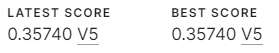

In [36]:
# Import .png
from IPython.display import Image
Image(filename='image.png')